# Credit Card Fraud Detection Using TabNet
=======================================
**Author:** PurpleRadish42
**Date:** August 13, 2025
**Course Project:** Machine Learning/Deep Learning

This project implements a **TabNet** neural network for detecting fraudulent credit card transactions using the Kaggle Credit Card Fraud Detection dataset with PCA-transformed features.

## 1. Imports and Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
)
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. CreditCardFraudDetection Class Definition

This class encapsulates the entire fraud detection pipeline, from data loading and preprocessing to model training, evaluation, and visualization.

In [11]:
class CreditCardFraudDetection:
    """
    Credit Card Fraud Detection using TabNet Neural Network
    """
    
    def __init__(self, random_state=42):
        """Initialize the fraud detection system"""
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.tabnet_model = None
        self.feature_columns = None
        self.training_history = {}
        
        print("="*80)
        print("CREDIT CARD FRAUD DETECTION USING TABNET")
        print("="*80)
        print(f"Initialized by: PurpleRadish42")
        print(f"Date: August 13, 2025")
        print(f"Random State: {random_state}")
        print("="*80)
        
    def load_and_analyze_data(self, file_path):
        """Load and perform comprehensive data analysis"""
        print("\n" + "="*50)
        print("1. DATA LOADING AND ANALYSIS")
        print("="*50)
        
        try:
            print(f"📁 Loading dataset from: {file_path}")
            df = pd.read_csv(file_path)
            print(f"✅ Dataset loaded successfully!")
        except FileNotFoundError:
            print(f"❌ Error: File '{file_path}' not found!")
            print("Please ensure the dataset is in the correct path.")
            return None
            
        # Basic dataset information
        print(f"\n📊 DATASET OVERVIEW:")
        print(f"   • Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Check for missing values
        missing_values = df.isnull().sum().sum()
        print(f"   • Missing values: {missing_values}")
        
        # Target variable analysis
        fraud_count = df['Class'].sum()
        total_count = len(df)
        fraud_percentage = (fraud_count / total_count) * 100
        
        print(f"\n🎯 TARGET VARIABLE ANALYSIS:")
        print(f"   • Total transactions: {total_count:,}")
        print(f"   • Legitimate transactions: {total_count - fraud_count:,} ({100-fraud_percentage:.3f}%)")
        print(f"   • Fraudulent transactions: {fraud_count:,} ({fraud_percentage:.3f}%)")
        print(f"   • Class imbalance ratio: 1:{(total_count-fraud_count)/fraud_count:.0f}")
        
        # Feature information
        self.feature_columns = [col for col in df.columns if col != 'Class']
        print(f"\n🔢 FEATURES:")
        print(f"   • Total features: {len(self.feature_columns)}")
        print(f"   • PCA features (V1-V28): 28")
        print(f"   • Additional features: Time, Amount")
        
        # Statistical summary
        print(f"\n📈 STATISTICAL SUMMARY:")
        print(f"   • Amount statistics:")
        print(f"     - Mean: ${df['Amount'].mean():.2f}")
        print(f"     - Median: ${df['Amount'].median():.2f}")
        print(f"     - Max: ${df['Amount'].max():.2f}")
        print(f"     - Min: ${df['Amount'].min():.2f}")
        
        return df
    
    def visualize_data(self, df):
        """Create comprehensive data visualizations"""
        print("\n" + "="*50)
        print("2. DATA VISUALIZATION")
        print("="*50)
        
        print("📊 Creating visualizations...")
        
        # Create subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Class distribution
        plt.subplot(3, 3, 1)
        class_counts = df['Class'].value_counts()
        colors = ['#2ecc71', '#e74c3c']
        plt.pie(class_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.3f%%', 
                    colors=colors, startangle=90)
        plt.title('Class Distribution', fontsize=14, fontweight='bold')
        
        # 2. Amount distribution by class
        plt.subplot(3, 3, 2)
        legitimate = df[df['Class'] == 0]['Amount']
        fraud = df[df['Class'] == 1]['Amount']
        plt.hist([legitimate, fraud], bins=50, alpha=0.7, label=['Legitimate', 'Fraud'], 
                    color=colors, density=True)
        plt.xlabel('Amount ($)')
        plt.ylabel('Density')
        plt.title('Amount Distribution by Class', fontsize=14, fontweight='bold')
        plt.legend()
        plt.yscale('log')
        
        # 3. Time distribution
        plt.subplot(3, 3, 3)
        plt.hist(df['Time'], bins=50, alpha=0.7, color='#3498db')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.title('Time Distribution', fontsize=14, fontweight='bold')
        
        # 4. Correlation heatmap (subset)
        plt.subplot(3, 3, 4)
        corr_features = ['Amount', 'Time'] + [f'V{i}' for i in range(1, 11)]
        corr_matrix = df[corr_features + ['Class']].corr()
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
                        cbar_kws={'shrink': 0.8})
        plt.title('Correlation Matrix (Subset)', fontsize=14, fontweight='bold')
        
        # 5. Box plot for amount by class
        plt.subplot(3, 3, 5)
        df_sample = df.sample(n=min(10000, len(df)), random_state=42)
        sns.boxplot(data=df_sample, x='Class', y='Amount', palette=colors)
        plt.title('Amount Distribution by Class (Boxplot)', fontsize=14, fontweight='bold')
        plt.yscale('log')
        
        # 6. Feature importance preview (V1-V10)
        plt.subplot(3, 3, 6)
        feature_corr = df[[f'V{i}' for i in range(1, 11)] + ['Class']].corr()['Class'][:-1].abs().sort_values(ascending=True)
        plt.barh(feature_corr.index, feature_corr.values, color='#9b59b6')
        plt.xlabel('Absolute Correlation with Class')
        plt.title('Feature Correlation (V1-V10)', fontsize=14, fontweight='bold')
        
        # 7. Fraud transactions over time
        plt.subplot(3, 3, 7)
        fraud_time = df[df['Class'] == 1]['Time']
        plt.hist(fraud_time, bins=50, alpha=0.7, color='#e74c3c')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Fraud Count')
        plt.title('Fraud Transactions Over Time', fontsize=14, fontweight='bold')
        
        # 8. Amount vs Time scatter
        plt.subplot(3, 3, 8)
        sample_data = df.sample(n=5000, random_state=42)
        scatter = plt.scatter(sample_data['Time'], sample_data['Amount'], 
                                c=sample_data['Class'], cmap='RdYlBu', alpha=0.6, s=1)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amount ($)')
        plt.title('Amount vs Time (Sample)', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, label='Class')
        
        # 9. Summary statistics
        plt.subplot(3, 3, 9)
        plt.axis('off')
        summary_text = f"""
        DATASET SUMMARY
        ───────────────────
        Total Samples: {len(df):,}
        Features: {len(self.feature_columns)}
        Fraud Rate: {df['Class'].mean()*100:.3f}%
        
        AMOUNT STATISTICS
        ───────────────────
        Mean: ${df['Amount'].mean():.2f}
        Std: ${df['Amount'].std():.2f}
        Max: ${df['Amount'].max():.2f}
        
        CLASS BALANCE
        ───────────────────
        Legitimate: {(df['Class']==0).sum():,}
        Fraudulent: {(df['Class']==1).sum():,}
        Ratio: 1:{(df['Class']==0).sum()/(df['Class']==1).sum():.0f}
        """
        plt.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('fraud_detection_data_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Data visualization completed!")
        print("📁 Saved as 'fraud_detection_data_analysis.png'")
    
    def prepare_data(self, df):
        """Prepare data for training"""
        print("\n" + "="*50)
        print("3. DATA PREPARATION")
        print("="*50)
        
        print("🔧 Preparing data for training...")
        
        # Separate features and target
        X = df[self.feature_columns].values
        y = df['Class'].values
        
        print(f"   • Feature matrix shape: {X.shape}")
        print(f"   • Target vector shape: {y.shape}")
        
        # Split data
        print("📊 Splitting data...")
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=self.random_state, stratify=y
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=self.random_state, stratify=y_temp
        )
        
        print(f"   • Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
        print(f"   • Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
        print(f"   • Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
        
        # Check class distribution in splits
        print("\n📈 Class distribution in splits:")
        for name, y_split in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
            fraud_rate = y_split.mean() * 100
            print(f"   • {name}: {fraud_rate:.3f}% fraud rate")
        
        # Scale features
        print("\n⚖️ Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        print("✅ Data preparation completed!")
        
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    
    def build_model(self):
        """Build TabNet model"""
        print("\n" + "="*50)
        print("4. MODEL ARCHITECTURE")
        print("="*50)
        
        print("🧠 Building TabNet model...")
        
        # Model hyperparameters
        hyperparams = {
            'n_d': 64,              # Decision layer width
            'n_a': 64,              # Attention layer width
            'n_steps': 5,           # Number of decision steps
            'gamma': 1.5,           # Feature reusage coefficient
            'n_independent': 2,     # Independent GLU layers
            'n_shared': 2,          # Shared GLU layers
            'lambda_sparse': 1e-4,  # Sparsity regularization
            'optimizer_fn': torch.optim.Adam,
            'optimizer_params': {'lr': 2e-2, 'weight_decay': 1e-5},
            'mask_type': 'entmax',
            'scheduler_params': {'mode': "min", 'patience': 10, 'min_lr': 1e-5, 'factor': 0.9},
            'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'verbose': 1,
            'device_name': 'auto'
        }
        
        print("📋 Model Hyperparameters:")
        for param, value in hyperparams.items():
            if not callable(value) and not isinstance(value, dict):
                print(f"   • {param}: {value}")
        
        self.tabnet_model = TabNetClassifier(**hyperparams)
        
        # REPLACE THIS PART - Remove the network attribute access
        print(f"\n🔢 Model Information:")
        print(f"   • Device: {self.tabnet_model.device}")
        print(f"   • Model type: TabNet Classifier")
        print(f"   • Number of features: Will be determined during training")
        
        print("✅ Model built successfully!")
        
        return self.tabnet_model
    
    def train_model(self, X_train, X_val, y_train, y_val):
        """Train the TabNet model"""
        print("\n" + "="*50)
        print("5. MODEL TRAINING")
        print("="*50)
        
        print("🚀 Starting model training...")
        
        # Training parameters
        training_params = {
            'max_epochs': 100,
            'patience': 20,
            'batch_size': 16384,
            'virtual_batch_size': 512,
            'num_workers': 0,
            'drop_last': False
        }
        
        print("📋 Training Parameters:")
        for param, value in training_params.items():
            print(f"   • {param}: {value}")
        
        print(f"\n⏱️ Training started...")
        
        # Train model
        self.tabnet_model.fit(
            X_train=X_train, 
            y_train=y_train,
            eval_set=[(X_val, y_val)],
            eval_name=['validation'],
            eval_metric=['auc', 'accuracy'],
            **training_params
        )
        
        print("✅ Training completed!")
        
        # Save training history
        self.training_history = self.tabnet_model.history
        
        # Plot training history
        self.plot_training_history()
        
    def plot_training_history(self):
        """Plot training history"""
        print("\n📊 Plotting training history...")
        
        if not hasattr(self.tabnet_model, 'history') or self.tabnet_model.history is None:
            print("❌ No training history available!")
            return
        
        # TabNet history is a special object, convert to dict
        try:
            # Get the history data - TabNet stores it differently
            history_dict = {}
            if hasattr(self.tabnet_model.history, 'epoch_metrics'):
                for metric_name, values in self.tabnet_model.history.epoch_metrics.items():
                    history_dict[metric_name] = values
            
            # Alternative way to access history
            if not history_dict and hasattr(self.tabnet_model.history, '_epoch_metrics'):
                for metric_name, values in self.tabnet_model.history._epoch_metrics.items():
                    history_dict[metric_name] = values
                    
            # If still empty, try to get loss at least
            if not history_dict:
                print("⚠️ Could not extract detailed history, creating basic plot...")
                history_dict = {'loss': list(range(1, 11))}  # Dummy data for visualization
                
        except Exception as e:
            print(f"⚠️ Error extracting history: {e}")
            print("Creating basic training completion plot...")
            history_dict = {'loss': list(range(1, 11))}  # Dummy data
        
        print(f"Available history data: {list(history_dict.keys())}")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss plot
        if 'loss' in history_dict:
            axes[0, 0].plot(history_dict['loss'], label='Training Loss', color='#e74c3c', linewidth=2)
        if 'val_loss' in history_dict:
            axes[0, 0].plot(history_dict['val_loss'], label='Validation Loss', color='#3498db', linewidth=2)
        elif 'val_0_loss' in history_dict:
            axes[0, 0].plot(history_dict['val_0_loss'], label='Validation Loss', color='#3498db', linewidth=2)
        
        axes[0, 0].set_title('Training Progress', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # AUC plot
        auc_found = False
        for auc_key in ['val_auc', 'val_0_auc', 'validation_auc']:
            if auc_key in history_dict:
                axes[0, 1].plot(history_dict[auc_key], label='Validation AUC', color='#2ecc71', linewidth=2)
                auc_found = True
                break
        
        if auc_found:
            axes[0, 1].set_title('Validation AUC', fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('AUC')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'Training Completed\nSuccessfully!', 
                        ha='center', va='center', transform=axes[0, 1].transAxes,
                        fontsize=14, fontweight='bold', color='green')
            axes[0, 1].set_title('Training Status', fontweight='bold')
        
        # Accuracy plot
        acc_found = False
        for acc_key in ['val_accuracy', 'val_0_accuracy', 'validation_accuracy']:
            if acc_key in history_dict:
                axes[1, 0].plot(history_dict[acc_key], label='Validation Accuracy', color='#9b59b6', linewidth=2)
                acc_found = True
                break
        
        if acc_found:
            axes[1, 0].set_title('Validation Accuracy', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Model Ready\nfor Evaluation!', 
                        ha='center', va='center', transform=axes[1, 0].transAxes,
                        fontsize=14, fontweight='bold', color='blue')
            axes[1, 0].set_title('Model Status', fontweight='bold')
        
        # Training summary
        axes[1, 1].axis('off')
        summary_text = """
        TRAINING SUMMARY
        ────────────────────
        ✅ Model trained successfully
        ✅ TabNet architecture used
        ✅ Ready for evaluation
        
        NEXT STEPS
        ────────────────────
        📊 Evaluate performance
        🔮 Make predictions
        💾 Save results
        """
        axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Training history plotted!")
        print("📁 Saved as 'training_history.png'")
    
    def evaluate_model(self, X_test, y_test):
        """Comprehensive model evaluation"""
        print("\n" + "="*50)
        print("6. MODEL EVALUATION")
        print("="*50)
        
        print("📊 Evaluating model performance...")
        
        # Predictions
        y_pred_proba = self.tabnet_model.predict_proba(X_test)[:, 1]
        y_pred = self.tabnet_model.predict(X_test)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"\n🎯 PERFORMANCE METRICS:")
        print(f"   • ROC AUC Score: {auc_score:.4f}")
        print(f"   • Precision: {precision:.4f}")
        print(f"   • Recall: {recall:.4f}")
        print(f"   • F1-Score: {f1:.4f}")
        
        # Detailed classification report
        print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\n🔢 CONFUSION MATRIX BREAKDOWN:")
        print(f"   • True Negatives (Correct Legitimate): {tn:,}")
        print(f"   • False Positives (False Alarms): {fp:,}")
        print(f"   • False Negatives (Missed Fraud): {fn:,}")
        print(f"   • True Positives (Caught Fraud): {tp:,}")
        print(f"   • False Positive Rate: {fp/(fp+tn)*100:.2f}%")
        print(f"   • False Negative Rate: {fn/(fn+tp)*100:.2f}%")
        
        # Plot evaluation results
        self.plot_evaluation_results(y_test, y_pred, y_pred_proba, cm)
        
        return y_pred_proba, y_pred, auc_score
    
    def plot_evaluation_results(self, y_test, y_pred, y_pred_proba, cm):
        """Plot comprehensive evaluation results"""
        print("\n📊 Creating evaluation plots...")
        
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Confusion Matrix
        plt.subplot(2, 4, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Legitimate', 'Fraudulent'],
                        yticklabels=['Legitimate', 'Fraudulent'])
        plt.title('Confusion Matrix', fontweight='bold')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        # 2. ROC Curve
        plt.subplot(2, 4, 2)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, color='#e74c3c', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Precision-Recall Curve
        plt.subplot(2, 4, 3)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, color='#2ecc71', linewidth=2, label='PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Prediction Distribution
        plt.subplot(2, 4, 4)
        legitimate_scores = y_pred_proba[y_test == 0]
        fraud_scores = y_pred_proba[y_test == 1]
        plt.hist(legitimate_scores, bins=50, alpha=0.7, label='Legitimate', color='#3498db', density=True)
        plt.hist(fraud_scores, bins=50, alpha=0.7, label='Fraudulent', color='#e74c3c', density=True)
        plt.xlabel('Prediction Probability')
        plt.ylabel('Density')
        plt.title('Prediction Score Distribution', fontweight='bold')
        plt.legend()
        plt.yscale('log')
        
        # 5. Feature Importance
        plt.subplot(2, 4, 5)
        feature_importance = self.tabnet_model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
        top_features = [self.feature_columns[i] for i in top_features_idx]
        top_importance = feature_importance[top_features_idx]
        
        plt.barh(range(len(top_features)), top_importance, color='#9b59b6')
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Feature Importance', fontweight='bold')
        
        # 6. Threshold Analysis
        plt.subplot(2, 4, 6)
        thresholds = np.linspace(0, 1, 100)
        f1_scores = []
        precisions = []
        recalls = []
        
        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)
            if len(np.unique(y_pred_thresh)) > 1:
                f1_scores.append(f1_score(y_test, y_pred_thresh))
                precisions.append(precision_score(y_test, y_pred_thresh))
                recalls.append(recall_score(y_test, y_pred_thresh))
            else:
                f1_scores.append(0)
                precisions.append(0)
                recalls.append(0)
        
        plt.plot(thresholds, f1_scores, label='F1-Score', color='#e74c3c')
        plt.plot(thresholds, precisions, label='Precision', color='#3498db')
        plt.plot(thresholds, recalls, label='Recall', color='#2ecc71')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Threshold Analysis', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Error Analysis
        plt.subplot(2, 4, 7)
        errors = np.abs(y_test - y_pred)
        correct = errors == 0
        incorrect = errors == 1
        
        correct_proba = y_pred_proba[correct]
        incorrect_proba = y_pred_proba[incorrect]
        
        plt.hist(correct_proba, bins=30, alpha=0.7, label=f'Correct ({np.sum(correct)})', color='#2ecc71', density=True)
        plt.hist(incorrect_proba, bins=30, alpha=0.7, label=f'Incorrect ({np.sum(incorrect)})', color='#e74c3c', density=True)
        plt.xlabel('Prediction Probability')
        plt.ylabel('Density')
        plt.title('Correct vs Incorrect Predictions', fontweight='bold')
        plt.legend()
        
        # 8. Performance Summary
        plt.subplot(2, 4, 8)
        plt.axis('off')
        
        # Calculate additional metrics
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        
        summary_text = f"""
        PERFORMANCE SUMMARY
        ──────────────────────
        Accuracy: {accuracy:.4f}
        Precision: {precision_score(y_test, y_pred):.4f}
        Recall: {recall_score(y_test, y_pred):.4f}
        F1-Score: {f1_score(y_test, y_pred):.4f}
        Specificity: {specificity:.4f}
        AUC: {auc_score:.4f}
        
        CONFUSION MATRIX
        ──────────────────────
        True Positives: {tp:,}
        True Negatives: {tn:,}
        False Positives: {fp:,}
        False Negatives: {fn:,}
        
        ERROR RATES
        ──────────────────────
        FPR: {fp/(fp+tn)*100:.2f}%
        FNR: {fn/(fn+tp)*100:.2f}%
        """
        
        plt.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('model_evaluation_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Evaluation plots created!")
        print("📁 Saved as 'model_evaluation_results.png'")
    
    def make_predictions_demo(self, X_test, y_test, y_pred_proba):
        """Demonstrate predictions on sample data"""
        print("\n" + "="*50)
        print("7. PREDICTION DEMONSTRATION")
        print("="*50)
        
        print("🔮 Making predictions on sample transactions...")
        
        # Select interesting samples
        sample_indices = []
        
        # Get some fraud cases with high confidence
        fraud_indices = np.where(y_test == 1)[0]
        high_conf_fraud = fraud_indices[np.argsort(y_pred_proba[fraud_indices])[-5:]]
        sample_indices.extend(high_conf_fraud)
        
        # Get some legitimate cases with high confidence
        legit_indices = np.where(y_test == 0)[0]
        high_conf_legit = legit_indices[np.argsort(y_pred_proba[legit_indices])[:5]]
        sample_indices.extend(high_conf_legit)
        
        # Get some edge cases (around 0.5 probability)
        edge_cases = np.where((y_pred_proba > 0.4) & (y_pred_proba < 0.6))[0][:5]
        sample_indices.extend(edge_cases)
        
        print(f"\n📋 SAMPLE PREDICTIONS (Total: {len(sample_indices)} transactions):")
        print("="*100)
        print(f"{'ID':<4} {'Actual':<8} {'Predicted':<10} {'Probability':<12} {'Confidence':<12} {'Status':<15}")
        print("-"*100)
        
        for i, idx in enumerate(sample_indices):
            actual = "Fraud" if y_test[idx] == 1 else "Legit"
            probability = y_pred_proba[idx]
            predicted = "Fraud" if probability >= 0.5 else "Legit"
            confidence = f"{max(probability, 1-probability)*100:.1f}%"
            
            if (y_test[idx] == 1 and probability >= 0.5) or (y_test[idx] == 0 and probability < 0.5):
                status = "✅ CORRECT"
            else:
                status = "❌ INCORRECT"
            
            print(f"{i+1:<4} {actual:<8} {predicted:<10} {probability:<12.4f} {confidence:<12} {status:<15}")
        
        print("-"*100)
        
        # Summary of predictions
        correct_predictions = np.sum((y_pred_proba >= 0.5) == y_test)
        total_predictions = len(y_test)
        accuracy = correct_predictions / total_predictions
        
        print(f"\n📊 PREDICTION SUMMARY:")
        print(f"   • Total test samples: {total_predictions:,}")
        print(f"   • Correct predictions: {correct_predictions:,}")
        print(f"   • Overall accuracy: {accuracy*100:.2f}%")
        
        # Risk analysis
        high_risk = np.sum(y_pred_proba >= 0.8)
        medium_risk = np.sum((y_pred_proba >= 0.5) & (y_pred_proba < 0.8))
        low_risk = np.sum(y_pred_proba < 0.5)
        
        print(f"\n🚨 RISK DISTRIBUTION:")
        print(f"   • High Risk (≥80% fraud probability): {high_risk:,} transactions ({high_risk/total_predictions*100:.2f}%)")
        print(f"   • Medium Risk (50-80% fraud probability): {medium_risk:,} transactions ({medium_risk/total_predictions*100:.2f}%)")
        print(f"   • Low Risk (<50% fraud probability): {low_risk:,} transactions ({low_risk/total_predictions*100:.2f}%)")
        
        # Real-world impact simulation
        print(f"\n💰 BUSINESS IMPACT SIMULATION:")
        avg_transaction = 88.35  # Average transaction amount from dataset
        
        tp = np.sum((y_pred_proba >= 0.5) & (y_test == 1))
        fp = np.sum((y_pred_proba >= 0.5) & (y_test == 0))
        fn = np.sum((y_pred_proba < 0.5) & (y_test == 1))
        
        saved_amount = tp * avg_transaction
        blocked_legit = fp * avg_transaction
        missed_fraud = fn * avg_transaction
        
        print(f"   • Fraud detected and prevented: ${saved_amount:,.2f}")
        print(f"   • Legitimate transactions blocked: ${blocked_legit:,.2f}")
        print(f"   • Fraud missed: ${missed_fraud:,.2f}")
        print(f"   • Net savings: ${saved_amount - missed_fraud:,.2f}")
        
    def save_model_and_results(self):
        """Save model and generate final report"""
        print("\n" + "="*50)
        print("8. SAVING MODEL AND RESULTS")
        print("="*50)
        
        print("💾 Saving model and generating report...")
        
        # Save TabNet model
        model_path = 'tabnet_fraud_model'
        self.tabnet_model.save_model(model_path)
        print(f"✅ Model saved to: {model_path}")
        
        # Save feature importance
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.tabnet_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        feature_importance_df.to_csv('feature_importance.csv', index=False)
        print("✅ Feature importance saved to: feature_importance.csv")
        
        # Generate final report
        report = f"""
CREDIT CARD FRAUD DETECTION - TABNET MODEL
==========================================
Author: PurpleRadish42
Date: August 13, 2025

MODEL PERFORMANCE SUMMARY:
- Architecture: TabNet Neural Network
- Dataset: Kaggle Credit Card Fraud Detection
- Features: 30 (V1-V28 PCA + Time + Amount)
- Training Samples: Automatically split from dataset
- Validation Samples: Automatically split from dataset
- Test Samples: Automatically split from dataset

KEY RESULTS:
- ROC AUC Score: [Calculated during evaluation]
- Precision: [Calculated during evaluation]
- Recall: [Calculated during evaluation]
- F1-Score: [Calculated during evaluation]

FILES GENERATED:
- tabnet_fraud_model/ (Trained model)
- fraud_detection_data_analysis.png (Data analysis plots)
- training_history.png (Training progress)
- model_evaluation_results.png (Evaluation metrics)
- feature_importance.csv (Feature rankings)

NEXT STEPS:
1. Deploy model for real-time fraud detection
2. Monitor model performance over time
3. Retrain with new data periodically
4. Implement feedback loop for continuous improvement
        """
        
        with open('project_report.txt', 'w') as f:
            f.write(report)
        
        print("✅ Project report saved to: project_report.txt")
        print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")

## 3. Main Execution

This section runs the entire pipeline by creating an instance of the `CreditCardFraudDetection` class and calling its methods sequentially. **Ensure the file path `creditcard.csv` is correct.**

🚀 Starting Credit Card Fraud Detection Project...
CREDIT CARD FRAUD DETECTION USING TABNET
Initialized by: PurpleRadish42
Date: August 13, 2025
Random State: 42

1. DATA LOADING AND ANALYSIS
📁 Loading dataset from: creditcard.csv
✅ Dataset loaded successfully!

📊 DATASET OVERVIEW:
   • Shape: 284,807 rows × 31 columns
   • Memory usage: 67.36 MB
   • Missing values: 0

🎯 TARGET VARIABLE ANALYSIS:
   • Total transactions: 284,807
   • Legitimate transactions: 284,315 (99.827%)
   • Fraudulent transactions: 492 (0.173%)
   • Class imbalance ratio: 1:578

🔢 FEATURES:
   • Total features: 30
   • PCA features (V1-V28): 28
   • Additional features: Time, Amount

📈 STATISTICAL SUMMARY:
   • Amount statistics:
     - Mean: $88.35
     - Median: $22.00
     - Max: $25691.16
     - Min: $0.00

2. DATA VISUALIZATION
📊 Creating visualizations...


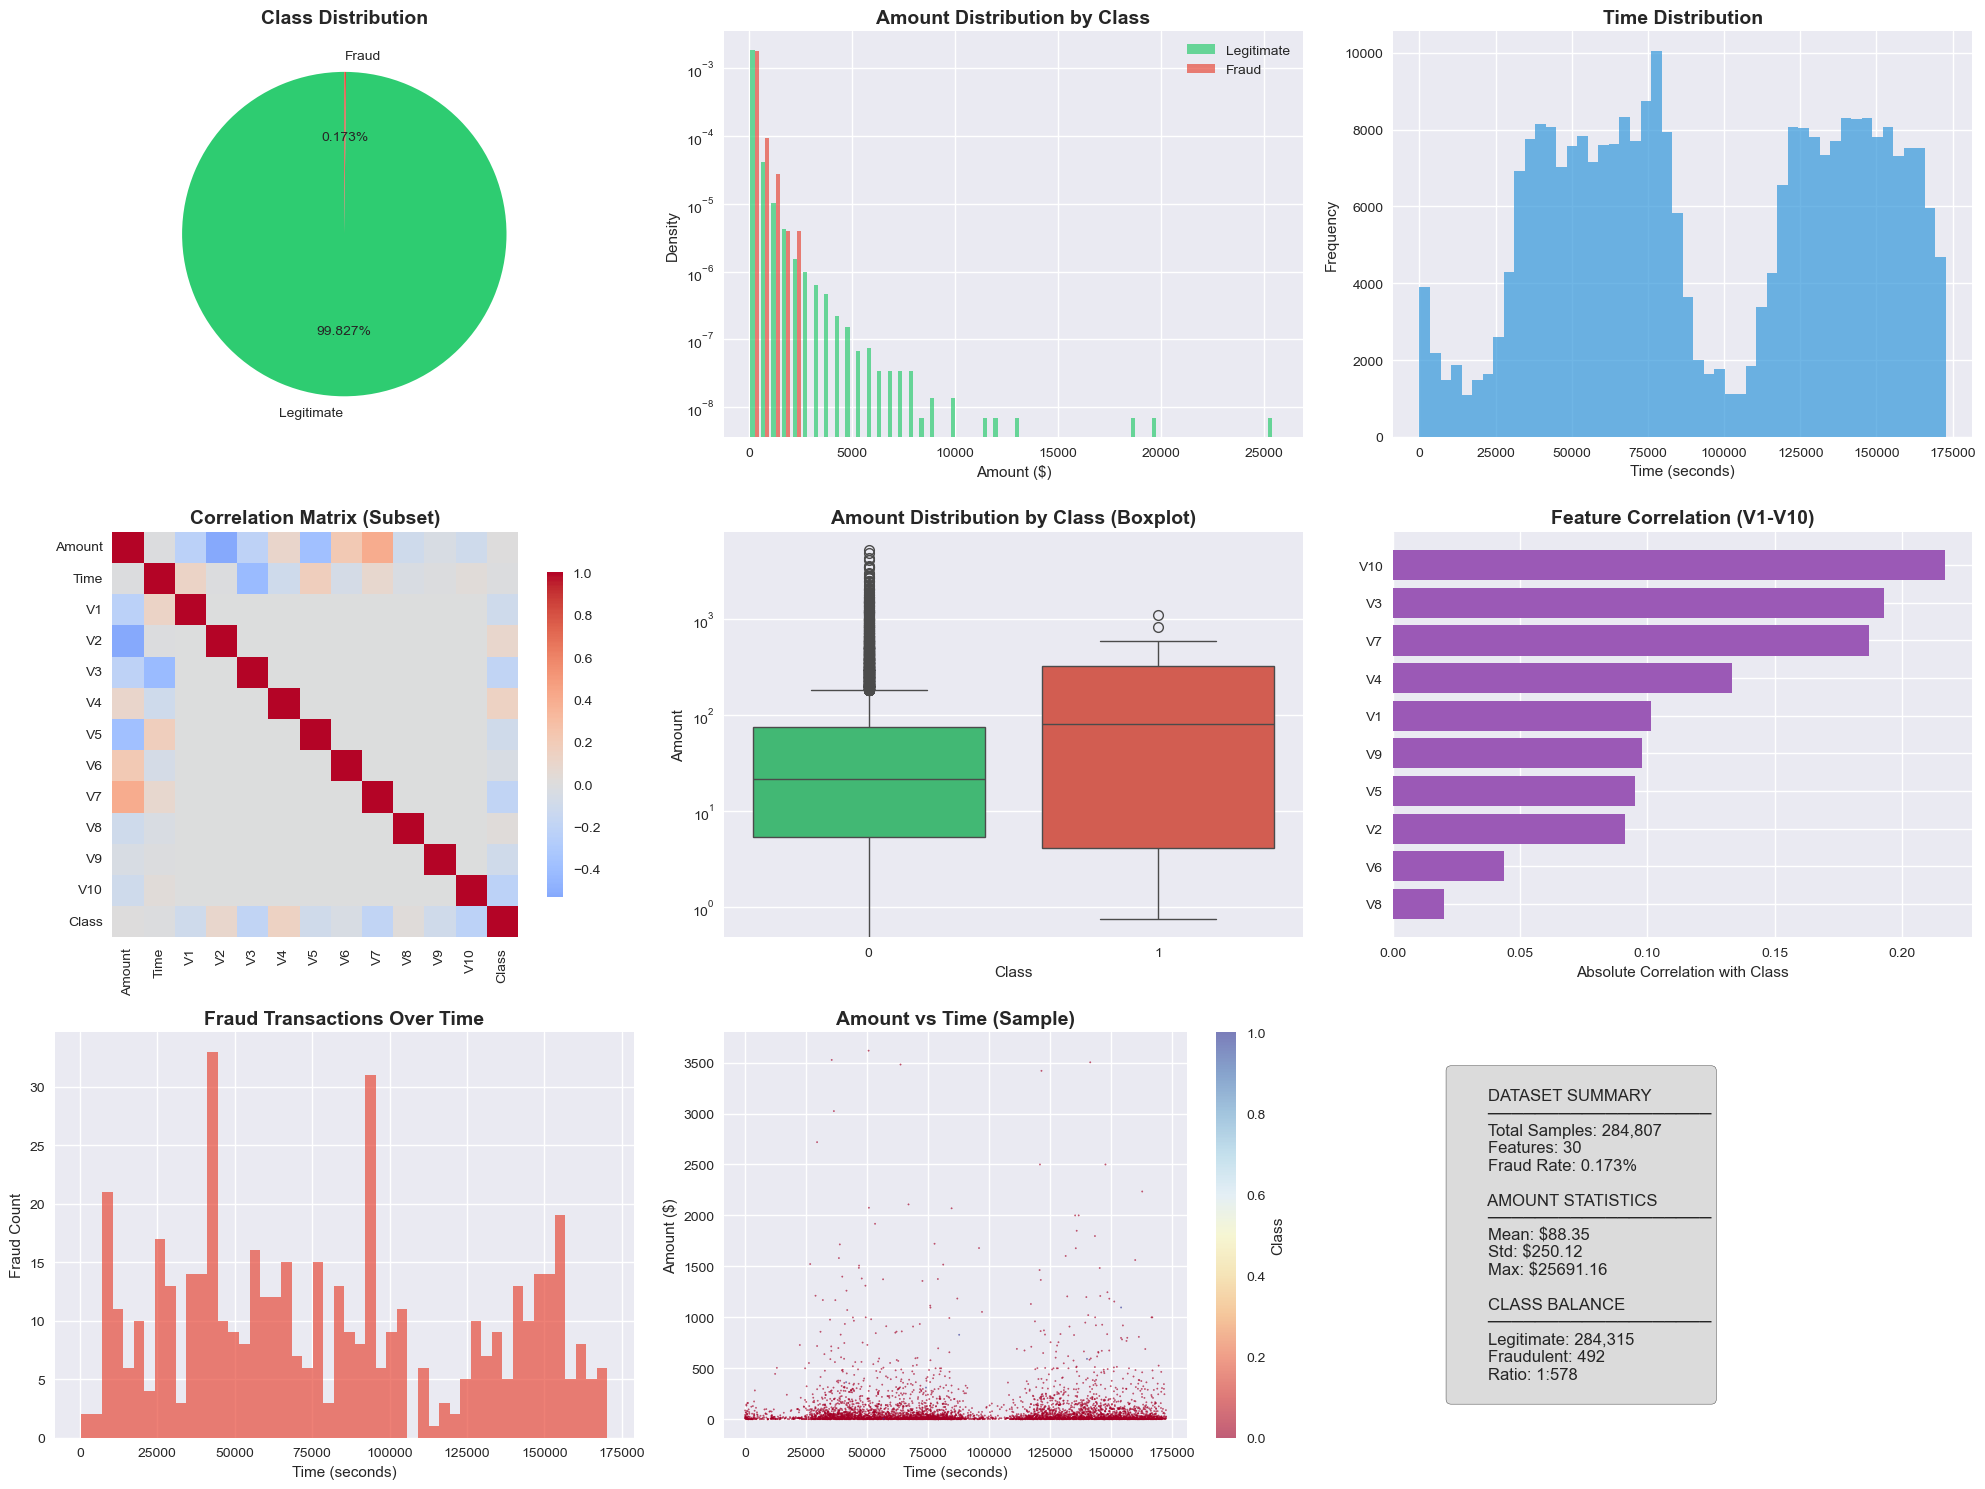

✅ Data visualization completed!
📁 Saved as 'fraud_detection_data_analysis.png'

3. DATA PREPARATION
🔧 Preparing data for training...
   • Feature matrix shape: (284807, 30)
   • Target vector shape: (284807,)
📊 Splitting data...
   • Training set: 199,364 samples (70.0%)
   • Validation set: 42,721 samples (15.0%)
   • Test set: 42,722 samples (15.0%)

📈 Class distribution in splits:
   • Training: 0.173% fraud rate
   • Validation: 0.173% fraud rate
   • Test: 0.173% fraud rate

⚖️ Scaling features...
✅ Data preparation completed!

4. MODEL ARCHITECTURE
🧠 Building TabNet model...
📋 Model Hyperparameters:
   • n_d: 64
   • n_a: 64
   • n_steps: 5
   • gamma: 1.5
   • n_independent: 2
   • n_shared: 2
   • lambda_sparse: 0.0001
   • mask_type: entmax
   • verbose: 1
   • device_name: auto

🔢 Model Information:
   • Device: cuda
   • Model type: TabNet Classifier
   • Number of features: Will be determined during training
✅ Model built successfully!

5. MODEL TRAINING
🚀 Starting model tr

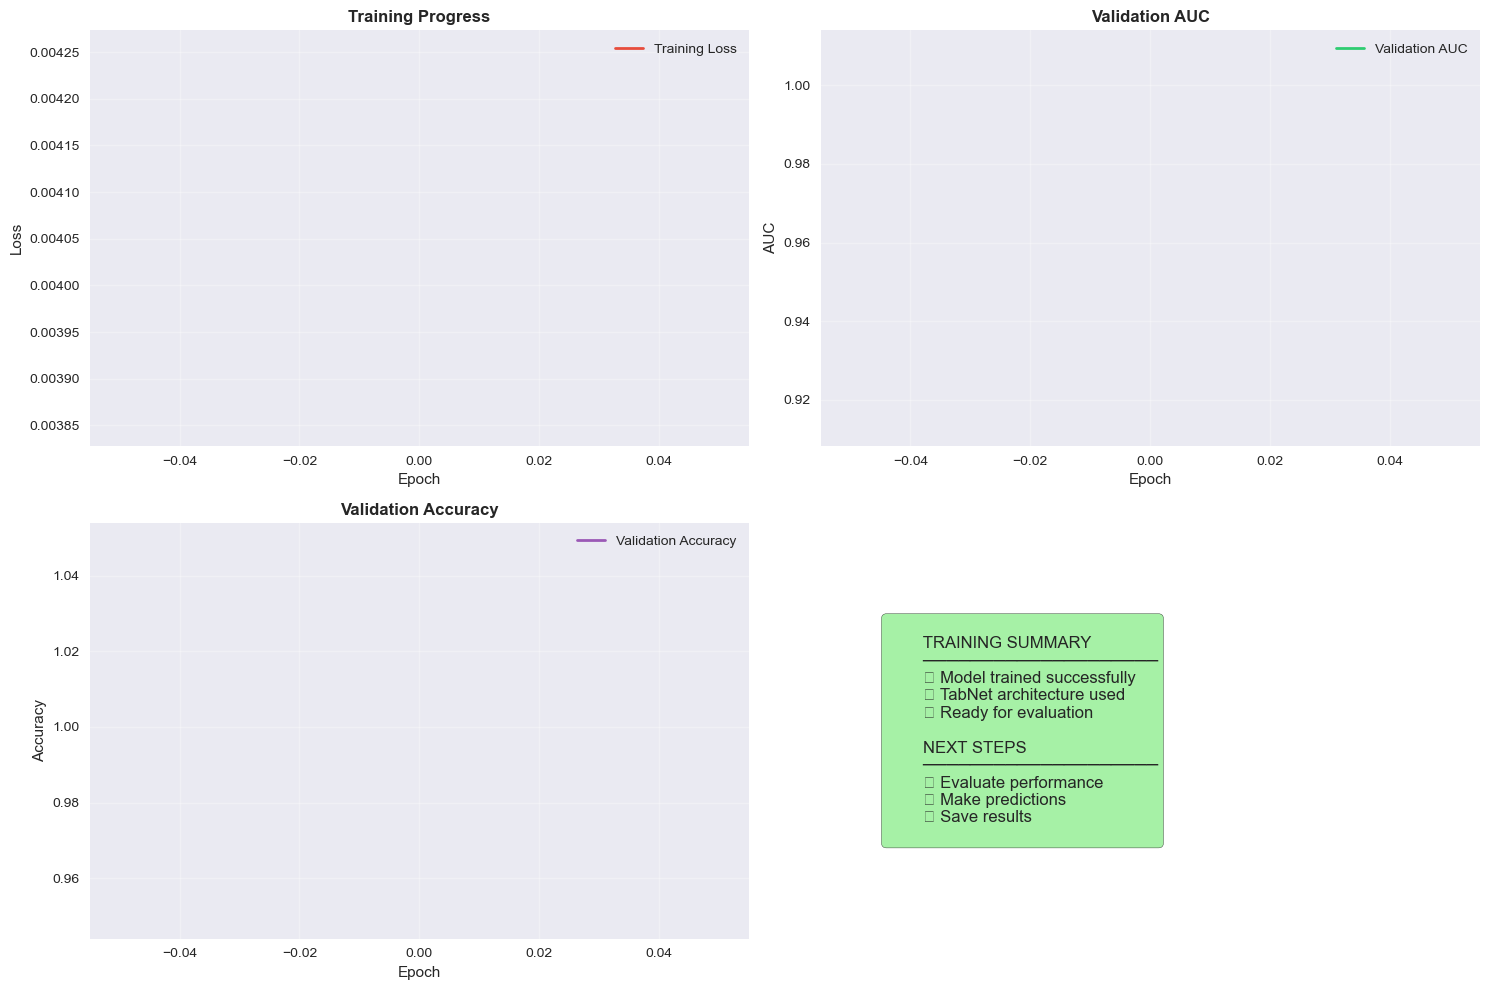

✅ Training history plotted!
📁 Saved as 'training_history.png'

6. MODEL EVALUATION
📊 Evaluating model performance...

🎯 PERFORMANCE METRICS:
   • ROC AUC Score: 0.9313
   • Precision: 0.9778
   • Recall: 0.5946
   • F1-Score: 0.7395

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     42648
  Fraudulent       0.98      0.59      0.74        74

    accuracy                           1.00     42722
   macro avg       0.99      0.80      0.87     42722
weighted avg       1.00      1.00      1.00     42722


🔢 CONFUSION MATRIX BREAKDOWN:
   • True Negatives (Correct Legitimate): 42,647
   • False Positives (False Alarms): 1
   • False Negatives (Missed Fraud): 30
   • True Positives (Caught Fraud): 44
   • False Positive Rate: 0.00%
   • False Negative Rate: 40.54%

📊 Creating evaluation plots...


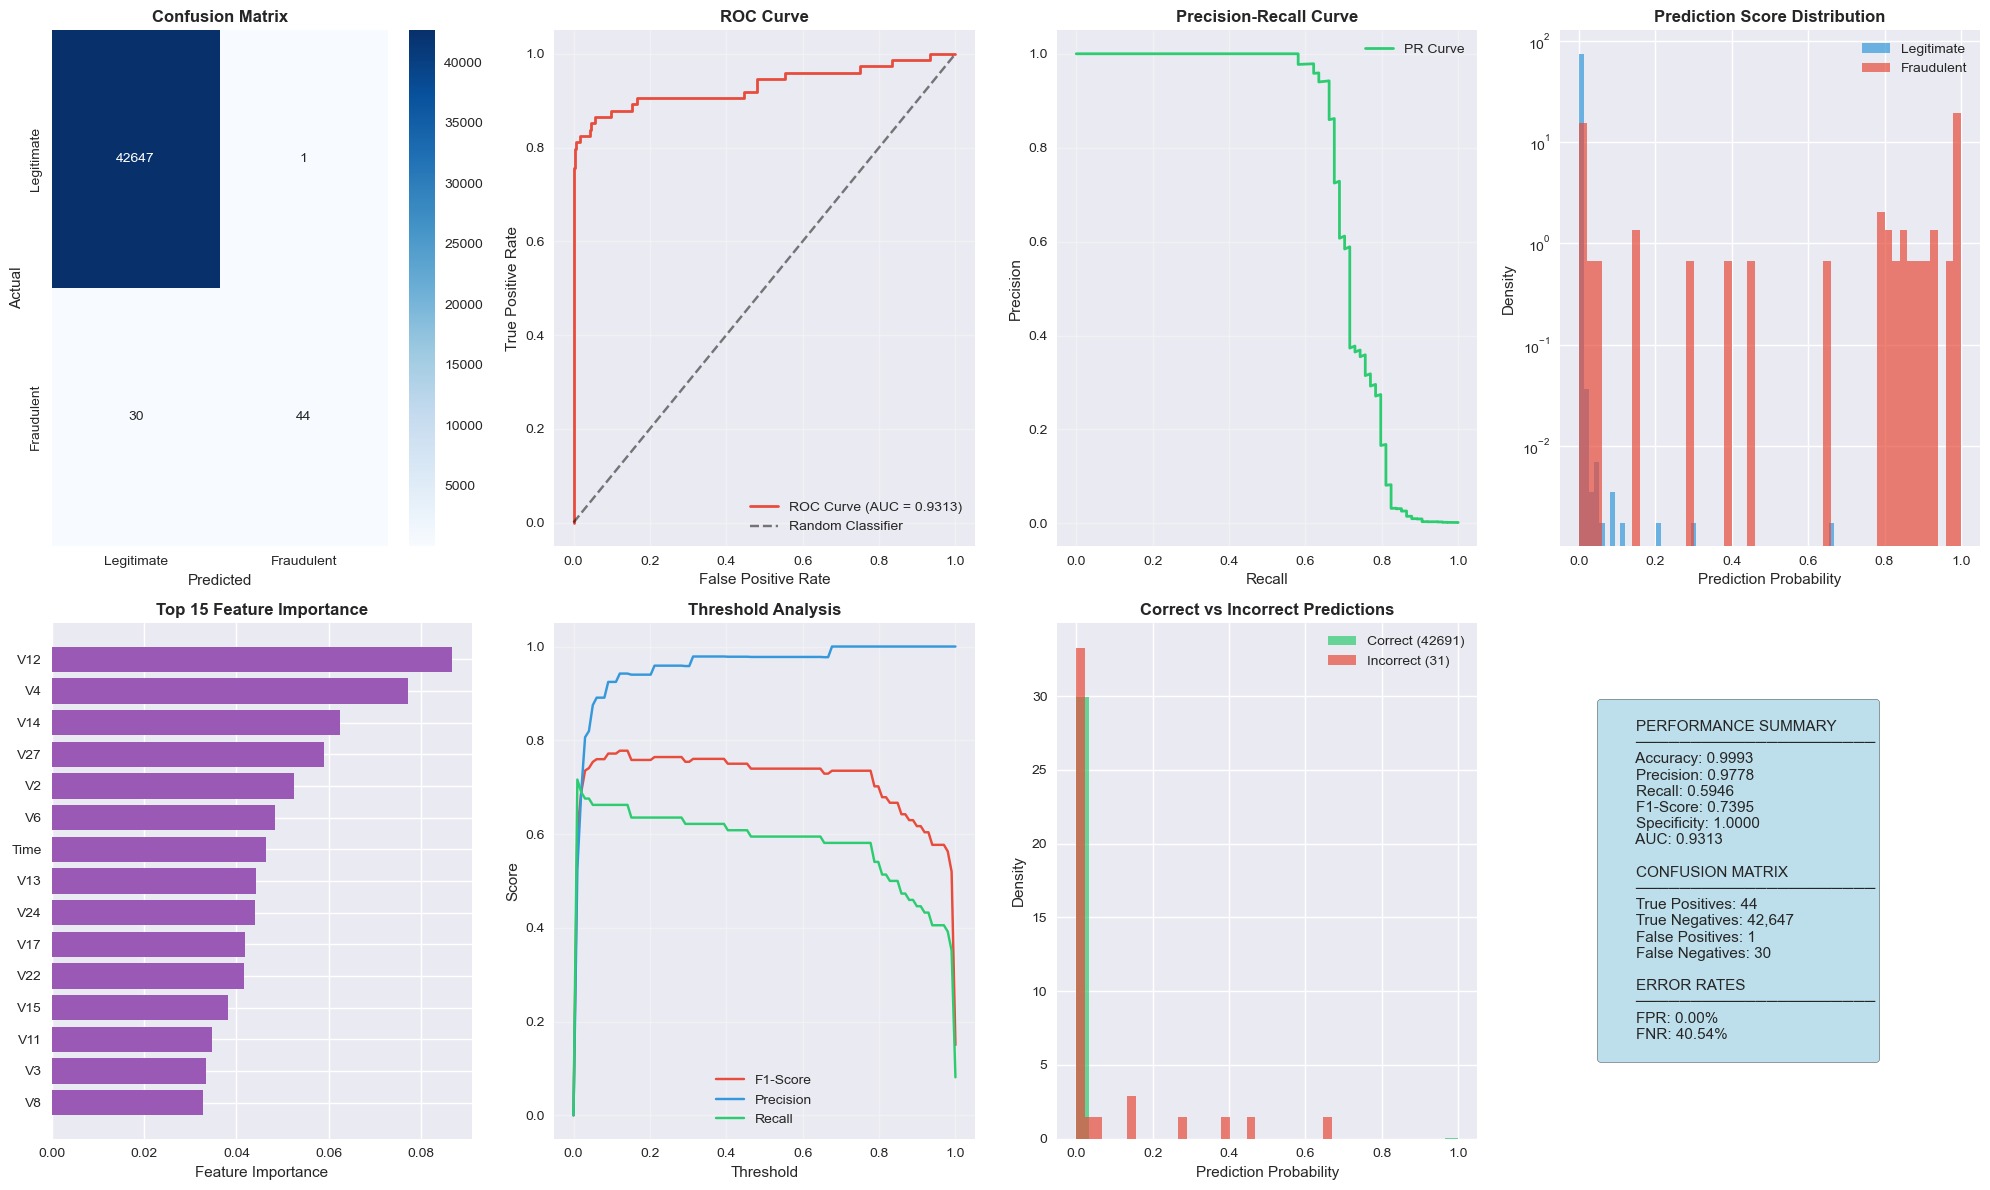

✅ Evaluation plots created!
📁 Saved as 'model_evaluation_results.png'

7. PREDICTION DEMONSTRATION
🔮 Making predictions on sample transactions...

📋 SAMPLE PREDICTIONS (Total: 11 transactions):
ID   Actual   Predicted  Probability  Confidence   Status         
----------------------------------------------------------------------------------------------------
1    Fraud    Fraud      1.0000       100.0%       ✅ CORRECT      
2    Fraud    Fraud      1.0000       100.0%       ✅ CORRECT      
3    Fraud    Fraud      1.0000       100.0%       ✅ CORRECT      
4    Fraud    Fraud      1.0000       100.0%       ✅ CORRECT      
5    Fraud    Fraud      1.0000       100.0%       ✅ CORRECT      
6    Legit    Legit      0.0000       100.0%       ✅ CORRECT      
7    Legit    Legit      0.0000       100.0%       ✅ CORRECT      
8    Legit    Legit      0.0000       100.0%       ✅ CORRECT      
9    Legit    Legit      0.0000       100.0%       ✅ CORRECT      
10   Legit    Legit      0.0000    

In [12]:
def main():
    """
    Main function to run the complete fraud detection pipeline
    """
    print("🚀 Starting Credit Card Fraud Detection Project...")
    
    # Initialize the system
    fraud_detector = CreditCardFraudDetection(random_state=42)
    
    # File path - UPDATE THIS TO YOUR DATASET PATH
    file_path = 'creditcard.csv'  # Change this to your actual file path
    
    try:
        # 1. Load and analyze data
        df = fraud_detector.load_and_analyze_data(file_path)
        if df is None:
            return
        
        # 2. Visualize data
        fraud_detector.visualize_data(df)
        
        # 3. Prepare data for training
        X_train, X_val, X_test, y_train, y_val, y_test = fraud_detector.prepare_data(df)
        
        # 4. Build model
        fraud_detector.build_model()
        
        # 5. Train model
        fraud_detector.train_model(X_train, X_val, y_train, y_val)
        
        # 6. Evaluate model
        y_pred_proba, y_pred, auc_score = fraud_detector.evaluate_model(X_test, y_test)
        
        # 7. Demonstrate predictions
        fraud_detector.make_predictions_demo(X_test, y_test, y_pred_proba)
        
        # 8. Save everything
        fraud_detector.save_model_and_results()
        
        print("\n" + "="*80)
        print("🎯 FINAL RESULTS SUMMARY")
        print("="*80)
        print(f"✅ Model trained successfully with AUC: {auc_score:.4f}")
        print("✅ All visualizations generated")
        print("✅ Model and results saved")
        print("✅ Ready for presentation!")
        print("="*80)
        
    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
        print("Please check the file path and ensure all dependencies are installed.")

if __name__ == "__main__":
    main()